In [1]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    is_colab = True
except:
    is_colab = False

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

random_state = 228

In [3]:
if is_colab:
    prepend_path = "/content/drive/MyDrive/Syncable/sjsu/data-228/DATA 228 Project Files"
else:
    prepend_path = "."
data_path = f"{prepend_path}/data/france_weather_energy.csv"
data_path_dates = f"{prepend_path}/data/france_weather_energy_with_date.csv"

In [4]:
df = pd.read_csv(data_path)
df.head()

,temp,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all,production_wind,production_solar
0,17.31,13.83,1021,80,1.42,20,99,4763.0,0.0
1,16.65,13.00,1021,79,0.67,35,77,4653.0,0.0
2,15.85,12.22,1020,79,1.25,350,24,4456.0,0.0
3,15.05,12.19,1020,83,1.61,358,1,4268.0,0.0
4,13.95,11.82,1020,87,1.44,349,5,3790.0,15.0


In [5]:
df.shape

(25771, 9)

In [6]:
y_cols = ["production_wind", "production_solar"]
X_ = df.drop(columns=y_cols)
y = df[y_cols]
display(X_.head())
display(y.head())

,temp,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all
0,17.31,13.83,1021,80,1.42,20,99
1,16.65,13.00,1021,79,0.67,35,77
2,15.85,12.22,1020,79,1.25,350,24
3,15.05,12.19,1020,83,1.61,358,1
4,13.95,11.82,1020,87,1.44,349,5


,production_wind,production_solar
0,4763.0,0.0
1,4653.0,0.0
2,4456.0,0.0
3,4268.0,0.0
4,3790.0,15.0


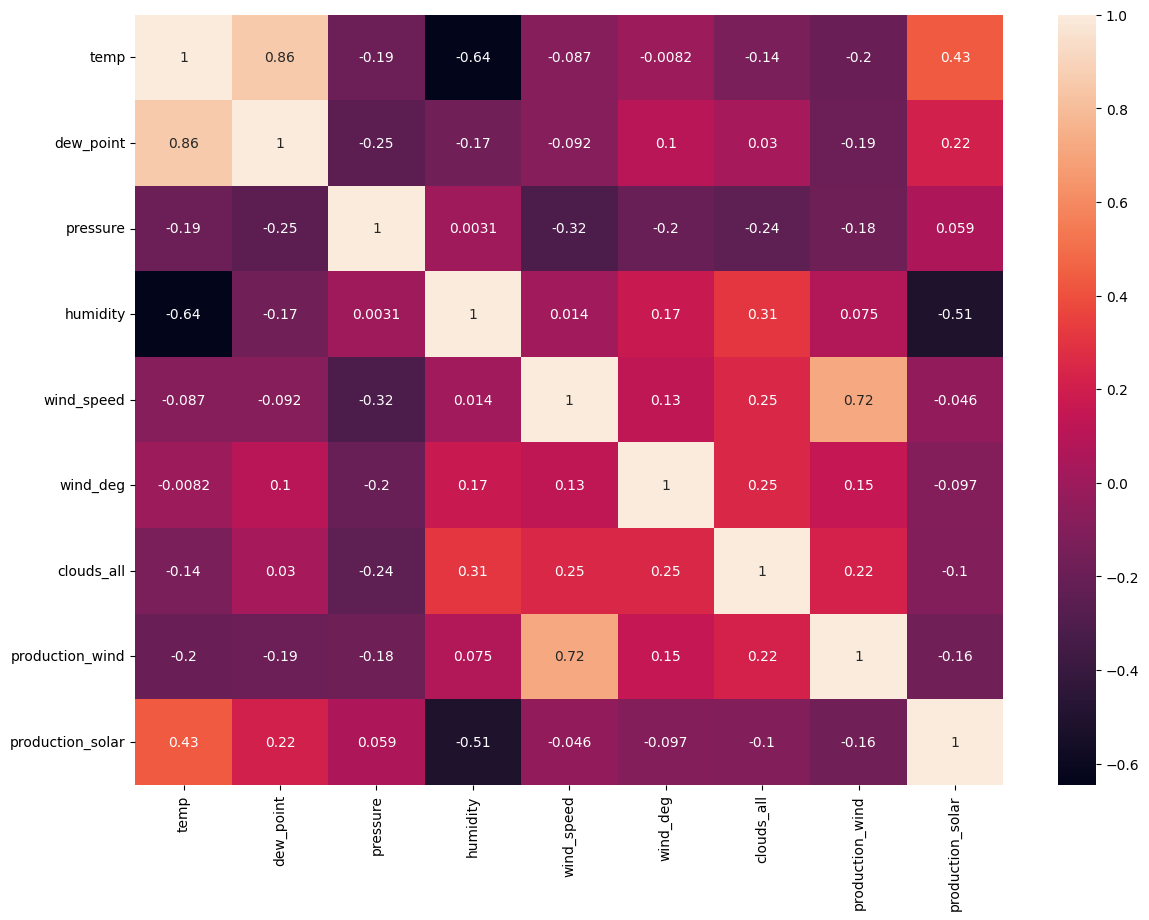

In [7]:
corr = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True)
plt.show()

In [8]:
significant_cols = corr[y_cols].abs().gt(0.1)
significant_cols.drop(index=y_cols, inplace=True)
display(significant_cols)

,production_wind,production_solar
temp,True,True
dew_point,True,True
pressure,True,False
humidity,False,True
wind_speed,True,False
wind_deg,True,False
clouds_all,True,True


In [9]:
wind_significant_cols = list(
    k for k, v in significant_cols["production_wind"].items() if v == True
)
solar_significant_cols = list(
    k for k, v in significant_cols["production_solar"].items() if v == True
)

print("Wind significant columns:", wind_significant_cols)
print("Solar significant columns:", solar_significant_cols)

Wind significant columns: ['temp', 'dew_point', 'pressure', 'wind_speed', 'wind_deg', 'clouds_all']
Solar significant columns: ['temp', 'dew_point', 'humidity', 'clouds_all']


In [10]:
standard_scalar = StandardScaler()
standard_scalar.fit(X_)
X = standard_scalar.transform(X_)
X = pd.DataFrame(X, columns=X_.columns)
X.head()

,temp,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all
0,0.702712,1.076552,0.369754,0.127433,-1.071404,-1.618815,0.913964
1,0.615891,0.929720,0.369754,0.067561,-1.552066,-1.465727,0.342972
2,0.510652,0.791732,0.243157,0.067561,-1.180354,1.749116,-1.032598
3,0.405414,0.786425,0.243157,0.307052,-0.949636,1.830763,-1.629544
4,0.260711,0.720970,0.243157,0.546543,-1.058586,1.738911,-1.525727


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

In [12]:
y_wind_train = y_train["production_wind"]
y_solar_train = y_train["production_solar"]
y_wind_test = y_test["production_wind"]
y_solar_test = y_test["production_solar"]

In [13]:
X_wind_train = X_train[wind_significant_cols]
X_solar_train = X_train[solar_significant_cols]
X_wind_test = X_test[wind_significant_cols]
X_solar_test = X_test[solar_significant_cols]

In [14]:
grid_params = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["rbf", "linear", "poly", "sigmoid"],
}

In [15]:
grid_search_wind = GridSearchCV(SVR(), grid_params, refit=True, n_jobs=-1, cv=3)
grid_search_solar = GridSearchCV(SVR(), grid_params, refit=True, n_jobs=-1, cv=3)

In [16]:
grid_search_wind.fit(X_wind_train, y_wind_train)

GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [17]:
grid_search_solar.fit(X_solar_train, y_solar_train)

GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [18]:
print("Best wind params:", grid_search_wind.best_params_)
print("Best solar params:", grid_search_solar.best_params_)

Best wind params: {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
Best solar params: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [19]:
y_wind_pred = grid_search_wind.predict(X_wind_test)
y_solar_pred = grid_search_solar.predict(X_solar_test)

In [20]:
print("Wind regression report:")
rmse_wind = mean_squared_error(y_wind_test, y_wind_pred, squared=False)
print(rmse_wind)

Wind regression report:
1926.37040833094


In [21]:
print("Solar regression report:")
rmse_solar = mean_squared_error(y_solar_test, y_solar_pred, squared=False)
print(rmse_solar)

Solar regression report:
1445.036238225557


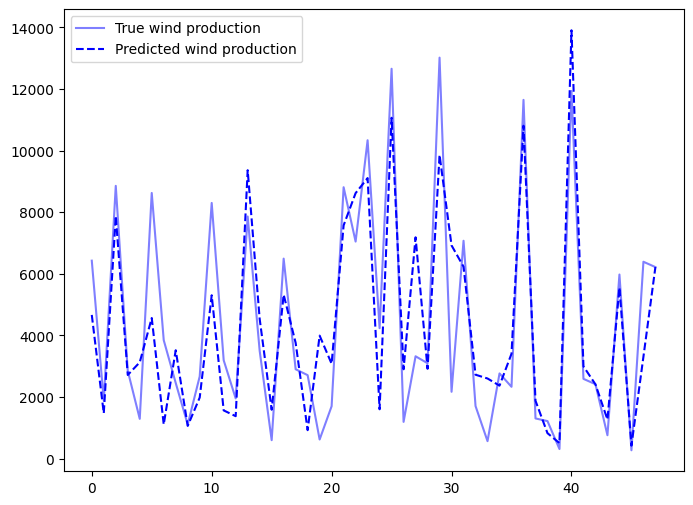

In [22]:
range_n = 24 * 2
figsize = (8, 6)
plt.figure(figsize=figsize)
plt.plot(
    y_wind_test.to_list()[:range_n],
    label="True wind production",
    color="blue",
    linestyle="solid",
    alpha=0.5,
)
plt.plot(
    y_wind_pred[:range_n],
    label="Predicted wind production",
    color="blue",
    linestyle="dashed",
)
plt.legend()
plt.show()

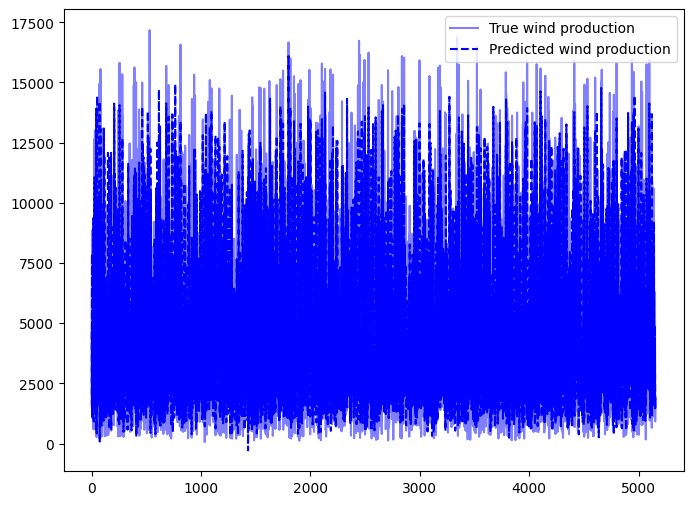

In [23]:
plt.figure(figsize=figsize)
plt.plot(
    y_wind_test.to_list(),
    label="True wind production",
    color="blue",
    linestyle="solid",
    alpha=0.5,
)
plt.plot(
    y_wind_pred,
    label="Predicted wind production",
    color="blue",
    linestyle="dashed",
)
plt.legend()
plt.show()

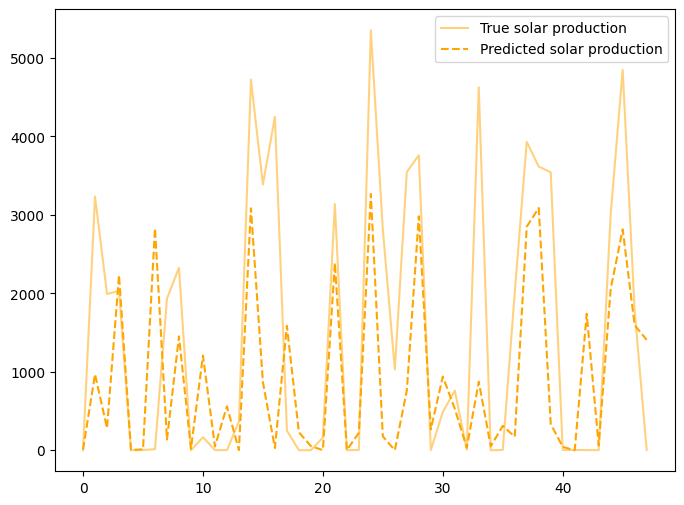

In [24]:
plt.figure(figsize=figsize)
plt.plot(
    y_solar_test.to_list()[:range_n],
    label="True solar production",
    color="orange",
    linestyle="solid",
    alpha=0.5,
)
plt.plot(
    y_solar_pred[:range_n],
    label="Predicted solar production",
    color="orange",
    linestyle="dashed",
)
plt.legend()
plt.show()

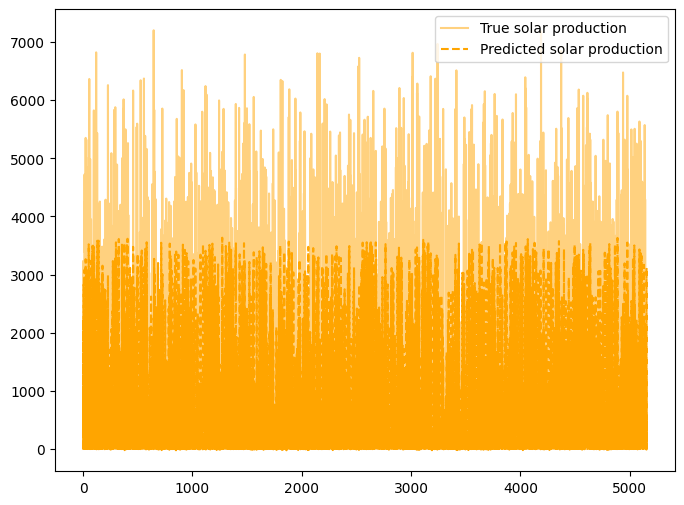

In [25]:
plt.figure(figsize=figsize)
plt.plot(
    y_solar_test.to_list(),
    label="True solar production",
    color="orange",
    linestyle="solid",
    alpha=0.5,
)
plt.plot(
    y_solar_pred,
    label="Predicted solar production",
    color="orange",
    linestyle="dashed",
)
plt.legend()
plt.show()

In [26]:
print("Total solar production:", np.sum(y_solar_pred))
print("Total wind production :", np.sum(y_wind_pred))

Total solar production: 3307106.532702736
Total wind production : 22358000.362883672


In [27]:
grid_params = {
    "estimator__gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "estimator__C": [0.1, 1, 10, 100, 1000],
}

In [28]:
# selected params from above tests that were common in both wind and solar prediction
grid = GridSearchCV(
    MultiOutputRegressor(SVR(kernel="rbf")),
    grid_params,
    refit=True,
    n_jobs=-1,
    cv=3,
)

In [29]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MultiOutputRegressor(estimator=SVR()), n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10, 100, 1000],
                         'estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001]})

In [30]:
y_multi_pred = grid.predict(X_test)

In [31]:
print("Regression report:")
rmse_multi = mean_squared_error(y_test, y_multi_pred, squared=False)
print(rmse_multi)

Regression report:
1570.0212269895014


In [32]:
print("Best combinded params:", grid.best_params_)

Best combinded params: {'estimator__C': 1000, 'estimator__gamma': 1}


In [33]:
df = pd.read_csv(data_path_dates)
X_ = df.drop(columns=y_cols)
y = df[y_cols]
dates = X_["dt_iso"]
X_ = X_.drop(columns=["dt_iso"])
X = standard_scalar.transform(X_)
X = pd.DataFrame(X, columns=X_.columns)

In [34]:
start_n = 100
range_n = 24 * 2 + start_n
y_pred = grid.predict(X[start_n:range_n])
y_true = y[start_n:range_n]

In [35]:
dates = pd.to_datetime(dates)
selected_dates = dates[start_n:range_n:8]

In [36]:
def format_date_time(dt):
    return dt.strftime("%Y-%m-%d\n%H:%M:%S")

In [37]:
formatted_dates = [format_date_time(dt) for dt in selected_dates]

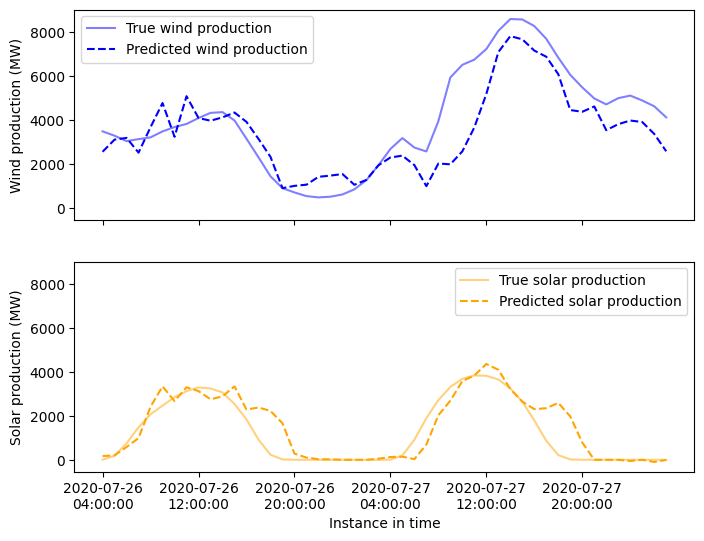

In [38]:
fig, ax = plt.subplots(2, figsize=figsize, sharex=True, sharey=True)
ax[0].plot(
    dates[start_n:range_n],
    y_true["production_wind"].to_list(),
    label="True wind production",
    color="blue",
    linestyle="solid",
    alpha=0.5,
)
ax[0].plot(
    dates[start_n:range_n],
    y_pred[:, 0],
    label="Predicted wind production",
    color="blue",
    linestyle="dashed",
)
ax[1].plot(
    dates[start_n:range_n],
    y_true["production_solar"].to_list(),
    label="True solar production",
    color="orange",
    linestyle="solid",
    alpha=0.5,
)
ax[1].plot(
    dates[start_n:range_n],
    y_pred[:, 1],
    label="Predicted solar production",
    color="orange",
    linestyle="dashed",
)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel("Wind production (MW)")
ax[1].set_ylabel("Solar production (MW)")
plt.xlabel("Instance in time")
plt.xticks(selected_dates, formatted_dates)
plt.show()

In [39]:
print("Total solar production:", np.sum(y_pred[:, 1]))
print("Total wind production :", np.sum(y_pred[:, 0]))

Total solar production: 72297.65017777808
Total wind production : 166161.26876673917


In [40]:
print("Comparing rmse values with original data standard deviation:")
print("Original wind production std:", df["production_wind"].std())
print("Original solar production std:", df["production_solar"].std())
print()
print("Predicted wind production rmse:", rmse_wind)
print("Predicted solar production rmse:", rmse_solar)
print("Multi-output regression rmse:", rmse_multi)

Comparing rmse values with original data standard deviation:
Original wind production std: 3491.703475406912
Original solar production std: 1597.2835878154126

Predicted wind production rmse: 1926.37040833094
Predicted solar production rmse: 1445.036238225557
Multi-output regression rmse: 1570.0212269895014


In [41]:
y_pred = grid.predict(X)
y_true = y
dates = pd.to_datetime(dates)
selected_dates = dates[::5000]
formatted_dates = [format_date_time(dt) for dt in selected_dates]

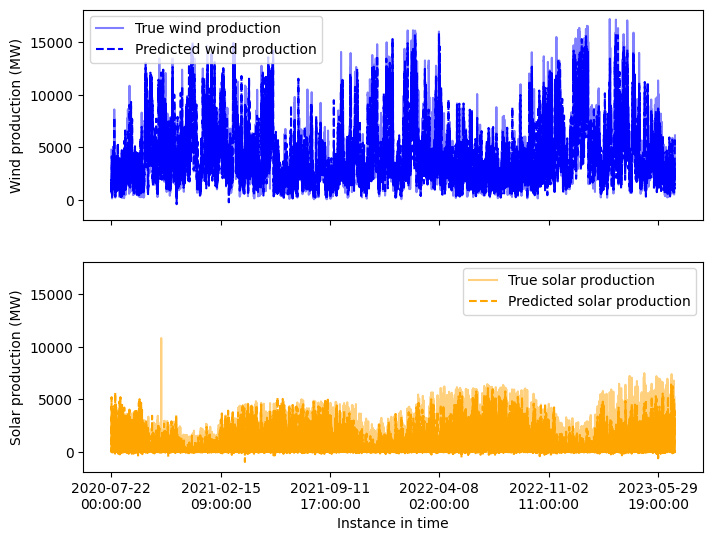

In [42]:
fig, ax = plt.subplots(2, figsize=figsize, sharex=True, sharey=True)
ax[0].plot(
    dates,
    y_true["production_wind"].to_list(),
    label="True wind production",
    color="blue",
    linestyle="solid",
    alpha=0.5,
)
ax[0].plot(
    dates,
    y_pred[:, 0],
    label="Predicted wind production",
    color="blue",
    linestyle="dashed",
)
ax[1].plot(
    dates,
    y_true["production_solar"].to_list(),
    label="True solar production",
    color="orange",
    linestyle="solid",
    alpha=0.5,
)
ax[1].plot(
    dates,
    y_pred[:, 1],
    label="Predicted solar production",
    color="orange",
    linestyle="dashed",
)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel("Wind production (MW)")
ax[1].set_ylabel("Solar production (MW)")
plt.xlabel("Instance in time")
plt.xticks(selected_dates, formatted_dates)
plt.show()